In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_pickle('test2.pkl')

# Display the first few rows of the dataframe to understand its structure
print(df.head())

   event_id                                               sent  \
0       701  Event(target=OpNode(User, InvokeMethod('order_...   
1       702  Event(target=OpNode(User, InvokeMethod('order_...   
2       703  Event(target=OpNode(User, InvokeMethod('order_...   
3       704  Event(target=OpNode(User, InvokeMethod('order_...   
4       705  Event(target=OpNode(User, InvokeMethod('order_...   

               sent_t                                                ret  \
0  (2, 1738342392523)  EventResult(event_id=701, result=True, metadat...   
1  (2, 1738342392523)  EventResult(event_id=702, result=True, metadat...   
2  (2, 1738342392523)  EventResult(event_id=703, result=True, metadat...   
3  (2, 1738342392523)  EventResult(event_id=704, result=True, metadat...   
4  (2, 1738342392523)  EventResult(event_id=705, result=True, metadat...   

                ret_t  roundtrip  flink_time  \
0  (2, 1738342395748)   3.218930    1.794561   
1  (2, 1738342394543)   2.013558    1.205442   
2 

<class 'pandas.core.series.Series'>
   event_id                                               sent  \
0       701  Event(target=OpNode(User, InvokeMethod('order_...   
1       702  Event(target=OpNode(User, InvokeMethod('order_...   
2       703  Event(target=OpNode(User, InvokeMethod('order_...   
3       704  Event(target=OpNode(User, InvokeMethod('order_...   
4       705  Event(target=OpNode(User, InvokeMethod('order_...   

               sent_t                                                ret  \
0  (2, 1738342392523)  EventResult(event_id=701, result=True, metadat...   
1  (2, 1738342392523)  EventResult(event_id=702, result=True, metadat...   
2  (2, 1738342392523)  EventResult(event_id=703, result=True, metadat...   
3  (2, 1738342392523)  EventResult(event_id=704, result=True, metadat...   
4  (2, 1738342392523)  EventResult(event_id=705, result=True, metadat...   

                ret_t  roundtrip  flink_time  \
0  (2, 1738342395748)   3.218930    1.794561   
1  (2, 1738342

Text(0, 0.5, 'latency (ms)')

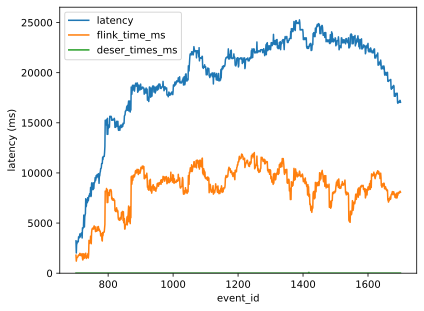

In [78]:
df['flink_time_ms'] = df['flink_time'] * 1000
df["deser_times_ms"] = df["deser_times"].apply(lambda x: sum(x)) * 1000
print(type(df['deser_times']))
print(df.head())
df.plot(x='event_id', y=['latency', 'flink_time_ms', 'deser_times_ms'], kind='line')
plt.ylim(bottom=0)
plt.ylabel('latency (ms)')